# Importing Libraries

In [ ]:
# Importing Libraries
import os
import sys
import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn as nn

from imblearn.over_sampling import SMOTE

# Audio processing and visualization libraries
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# Model utilities
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM, 
                                     Bidirectional, Dense, Multiply, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras_tuner import HyperModel, Hyperband

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\joday\AppData\Local\Temp\ipykernel_15608\174139237.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Paths and Labelling

In [ ]:
# Define paths (adjust for cross-platform compatibility)
base_path = os.getcwd()  # Use the current working directory as base

# Prompting users to enter the paths if not set
Ravdess = os.path.join(base_path, "Datasets/RAVDESS/audio_speech_actors_01-24/")
Crema = os.path.join(base_path, "Datasets/CREMAD/AudioWAV/")
Tess = os.path.join(base_path, "Datasets/TESS/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/")
Savee = os.path.join(base_path, "Datasets/SAVEE/ALL/")

# Check if paths exist
for path in [Ravdess, Crema, Tess, Savee]:
    if not os.path.exists(path):
        print(f"Warning: Directory {path} does not exist. Please check the path.")

In [ ]:
# Function to load dataset and map emotions to labels
def load_ravdess(path):
    ravdess_directory_list = os.listdir(path)
    file_emotion = []
    file_path = []

    for dir in ravdess_directory_list:
        actor = os.listdir(os.path.join(path, dir))
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(path, dir, file))

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    df = pd.concat([emotion_df, path_df], axis=1)
    df.Emotions.replace({1: 'neutral', 2: 'neutral', 3: 'sad', 4: 'angry', 5: 'happy'}, inplace=True)
    return df

,Emotions,Path
0,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
1,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
2,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
3,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
4,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...


In [ ]:
def load_crema(path):
    crema_directory_list = os.listdir(path)
    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        file_path.append(os.path.join(path, file))
        part = file.split('_')
        emotion_map = {'SAD': 'sad', 'ANG': 'angry', 'HAP': 'happy', 'NEU': 'neutral'}
        file_emotion.append(emotion_map.get(part[2], 'Unknown'))

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    return pd.concat([emotion_df, path_df], axis=1)

,Emotions,Path
0,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
1,happy,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
2,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
3,sad,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
4,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...


In [ ]:
def load_tess(path):
    tess_directory_list = os.listdir(path)
    file_emotion = []
    file_path = []

    for dir in tess_directory_list:
        directories = os.listdir(os.path.join(path, dir))
        for file in directories:
            part = file.split('.')[0].split('_')[2]
            file_emotion.append(part)
            file_path.append(os.path.join(path, dir, file))

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    return pd.concat([emotion_df, path_df], axis=1)

,Emotions,Path
0,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
1,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
2,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
3,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
4,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...


In [ ]:
def load_savee(path):
    savee_directory_list = os.listdir(path)
    file_emotion = []
    file_path = []

    for file in savee_directory_list:
        file_path.append(os.path.join(path, file))
        part = file.split('_')[1][:-6]
        emotion_map = {'a': 'angry', 'h': 'happy', 'n': 'neutral', 's': 'sad'}
        file_emotion.append(emotion_map.get(part, 'Unknown'))

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    return pd.concat([emotion_df, path_df], axis=1)

,Emotions,Path
0,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
1,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
2,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
3,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
4,angry,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...


# Creating Dataframe

In [ ]:
# Load datasets and combine them
Ravdess_df = load_ravdess(Ravdess)
Crema_df = load_crema(Crema)
Tess_df = load_tess(Tess)
Savee_df = load_savee(Savee)

data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
data_path.to_csv("data_path.csv", index=False)

,Emotions,Path
0,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
1,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
2,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
3,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...
4,neutral,/Users/joday/OneDrive/Desktop/FYP/SER/Datasets...


# Plotting Count of Emotions

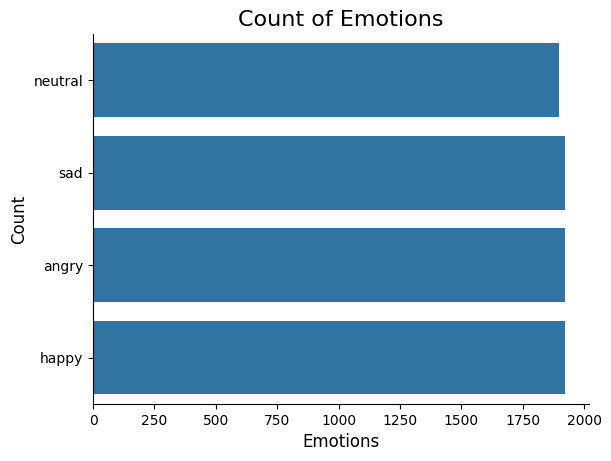

In [8]:
# Create plot of count of emotions

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Visualize Waveplot and Spectogram

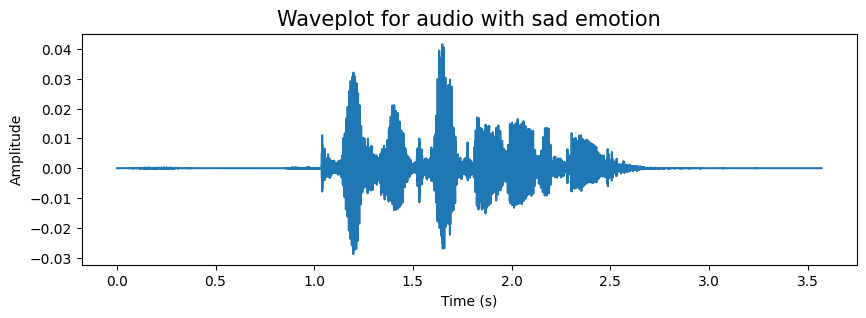

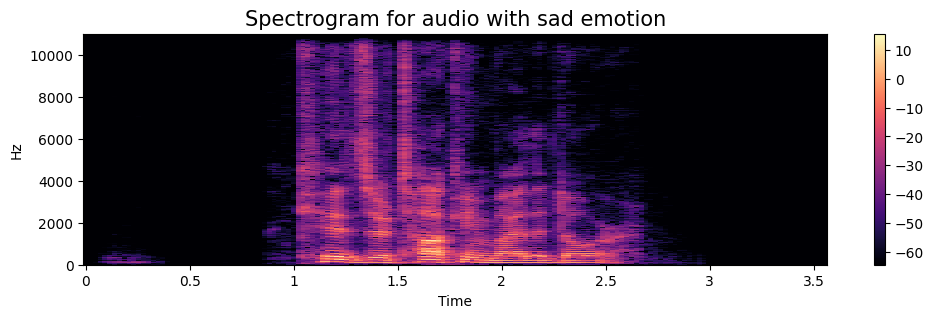

In [9]:
# Waveplot and Spectogram for Fear Emotion Example

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(np.arange(len(data)) / sr, data)  # Plot the waveform
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

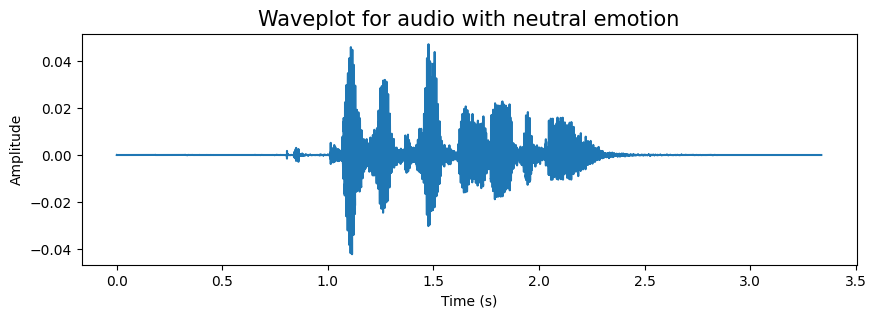

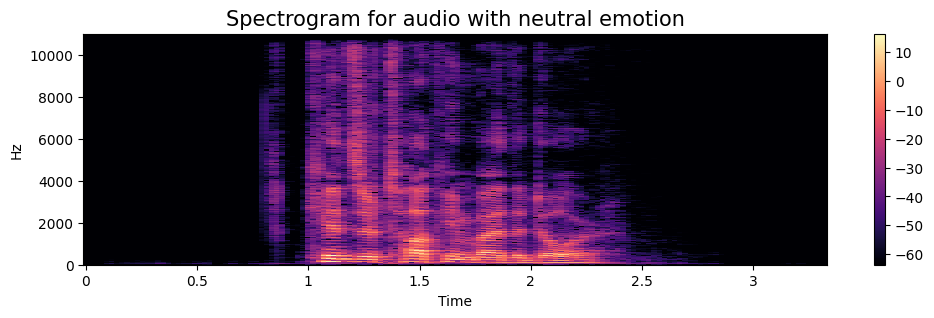

In [10]:
# Waveplot and Spectogram for Sad Emotion Example

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(np.arange(len(data)) / sr, data)  # Plot the waveform
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

emotion='neutral'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [ ]:
# Feature extraction and augmentation
def noise(data, noise_level=0.035, probability=0.5):
    if np.random.rand() < probability:
        noise_amp = noise_level * np.random.uniform() * np.amax(data)
        data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, low_rate=0.8, high_rate=1.2, probability=0.5):
    if np.random.rand() < probability:
        rate = np.random.uniform(low=low_rate, high=high_rate)
        data = librosa.effects.time_stretch(data, rate=rate)
    return data

def shift(data, shift_max=5, probability=0.5):
    if np.random.rand() < probability:
        shift_range = int(np.random.uniform(low=-shift_max, high=shift_max) * 1000)
        data = np.roll(data, shift_range)
    return data

def pitch(data, sampling_rate, pitch_factor_low=0.7, pitch_factor_high=1.3, probability=0.5):
    if np.random.rand() < probability:
        pitch_factor = np.random.uniform(low=pitch_factor_low, high=pitch_factor_high)
        data = librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)
    return data

# Features Extraction

In [ ]:
def extract_features(data, sample_rate):
    data, _ = librosa.effects.trim(data)
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    result = (result - np.mean(result)) / np.std(result)
    return result

def get_features(path, sample_rate=48000):
    data, sr = librosa.load(path, sr=sample_rate)
    augmented_data = [noise(data), stretch(data), pitch(data, sr), shift(data)]
    original_features = extract_features(data, sr)
    augmented_features = [extract_features(aug_data, sr) for aug_data in augmented_data if aug_data is not None]
    return [original_features] + augmented_features

In [ ]:
X, Y = [], []
for index, (path, emotion) in enumerate(zip(data_path.Path, data_path.Emotions)):
    features = get_features(path, sample_rate=48000)
    for feature in features:
        X.append(feature)
        Y.append(emotion)
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

Processed 100/7664 files.
Processed 200/7664 files.
Processed 300/7664 files.
Processed 400/7664 files.
Processed 500/7664 files.
Processed 600/7664 files.
Processed 700/7664 files.
Processed 800/7664 files.
Processed 900/7664 files.
Processed 1000/7664 files.
Processed 1100/7664 files.
Processed 1200/7664 files.
Processed 1300/7664 files.
Processed 1400/7664 files.
Processed 1500/7664 files.
Processed 1600/7664 files.
Processed 1700/7664 files.
Processed 1800/7664 files.
Processed 1900/7664 files.
Processed 2000/7664 files.
Processed 2100/7664 files.
Processed 2200/7664 files.
Processed 2300/7664 files.
Processed 2400/7664 files.
Processed 2500/7664 files.
Processed 2600/7664 files.
Processed 2700/7664 files.
Processed 2800/7664 files.
Processed 2900/7664 files.
Processed 3000/7664 files.
Processed 3100/7664 files.
Processed 3200/7664 files.
Processed 3300/7664 files.
Processed 3400/7664 files.
Processed 3500/7664 files.
Processed 3600/7664 files.
Processed 3700/7664 files.
Processed 

In [14]:
len(X), len(Y), data_path.Path.shape

(38320, 38320, (7664,))

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.061898,0.074822,0.075023,0.074296,0.07415,0.074317,0.074051,0.074248,0.074662,0.075021,...,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,neutral
1,0.061898,0.074822,0.075023,0.074296,0.07415,0.074317,0.074051,0.074248,0.074662,0.075021,...,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,neutral
2,0.061898,0.074822,0.075023,0.074296,0.07415,0.074317,0.074051,0.074248,0.074662,0.075021,...,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,neutral
3,0.061898,0.074822,0.075023,0.074296,0.07415,0.074317,0.074051,0.074248,0.074662,0.075021,...,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,neutral
4,0.061898,0.074822,0.075023,0.074296,0.07415,0.074317,0.074051,0.074248,0.074662,0.075021,...,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,0.060632,neutral


# Data Preparation

In [16]:
# Split data without one-hot encoding
X = Features.iloc[:, :-1].values
y = Features['labels'].values

In [17]:
# First split to separate out the test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# Second split to create the validation set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=0)

In [18]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [19]:
# One-hot encode the labels
encoder = OneHotEncoder()
y_train_smote = encoder.fit_transform(np.array(y_train_smote).reshape(-1, 1)).toarray()
y_val = encoder.transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = encoder.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [20]:
# Scale the features
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
# Reshape the data if necessary for your model input
X_train_smote = np.expand_dims(X_train_smote, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Hyperparameter Tuning

In [23]:
# Define the hypermodel class
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        inputs = Input(shape=self.input_shape)

        # First convolutional layer with hyperparameters for the number of filters and kernel size
        x = Conv1D(
            filters=hp.Int('filters_1', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]),
            strides=1,
            padding='same',
            activation='relu'
        )(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

        # Additional convolutional layers
        for i in range(hp.Int('conv_blocks', 1, 4, default=2)):  # Number of additional conv blocks
            x = Conv1D(
                filters=hp.Int(f'filters_conv_{i+2}', min_value=32, max_value=256, step=32),
                kernel_size=hp.Choice(f'kernel_size_conv_{i+2}', values=[3, 5, 7]),
                strides=1,
                padding='same',
                activation='relu'
            )(x)
            x = BatchNormalization()(x)
            x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
            x = Dropout(rate=hp.Float(f'dropout_conv_{i+1}', min_value=0.0, max_value=0.5, step=0.1))(x)

        # Bidirectional LSTM layer
        x = Bidirectional(LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
            return_sequences=True
        ))(x)

        # Attention mechanism
        attention_dim = 2 * hp.Int('lstm_units', min_value=32, max_value=128, step=32)
        attention_probs = Dense(attention_dim, activation='softmax', name='attention_vec')(x)
        attention_mul = Multiply()([x, attention_probs])
        attention_mul = Lambda(lambda xin: K.sum(xin, axis=1))(attention_mul)

        # Fully connected layer
        y = Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(attention_mul)
        y = Dropout(rate=hp.Float('dropout_final', min_value=0.0, max_value=0.5, step=0.1))(y)

        # Output layer
        outputs = Dense(units=self.num_classes, activation='softmax')(y)
        
        model = Model(inputs=inputs, outputs=outputs)

        # Hyperparameters for the optimizer
        optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

        if optimizer_choice == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_choice == 'sgd':
            optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
        else:
            optimizer = RMSprop(learning_rate=learning_rate)

        # Define batch_size as a hyperparameter inside the build method
        batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256])

        # Compile the model with the chosen optimizer and hyperparameters
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Return only the model
        return model

In [24]:
# Instantiate the hypermodel
hypermodel = CNNHyperModel(input_shape=(X_train_smote.shape[1], 1), num_classes=4)

In [25]:
# Instantiate the tuner
tuner = Hyperband(
    hypermodel.build,  # Pass the build method directly
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hptv2',
    project_name='hyperparameter_tuning'
)

Reloading Tuner from hptv2\hyperparameter_tuning\tuner0.json


In [26]:
# Early stopping callback to stop training if no improvement in val_accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [27]:
# Start the hyperparameter search with early stopping callback
tuner.search(
    X_train_smote, y_train_smote,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

In [28]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Modelling and Training

In [29]:
# Instantiate the hypermodel with the best hyperparameters
input_shape = (X_train_smote.shape[1], 1)
hypermodel = CNNHyperModel(input_shape, num_classes=4)

# Build the model using the best hyperparameters and display its summary
model = hypermodel.build(best_hps)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 162, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 162, 32)              128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 162, 32)              128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 81, 32)               0         ['batch_normalization[0]

In [30]:
# Callbacks
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [31]:
# Get the number of epochs and batch size with default values if they were not tuned
epochs = best_hps.get('epochs') if 'epochs' in best_hps else 100
batch_size = best_hps.get('batch_size') if 'batch_size' in best_hps else 64

In [32]:
# Train the model with the best hyperparameters
history = model.fit(
    X_train_smote, y_train_smote,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[rlrp, early_stopping, model_checkpoint]
)

Epoch 1/100


725/725 [==============================] - ETA: 0s - loss: 0.9647 - accuracy: 0.5774
Epoch 1: val_loss improved from inf to 0.79691, saving model to best_model.h5
725/725 [==============================] - 54s 60ms/step - loss: 0.9647 - accuracy: 0.5774 - val_loss: 0.7969 - val_accuracy: 0.6604 - lr: 5.7253e-04
Epoch 2/100
724/725 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.6632
Epoch 2: val_loss improved from 0.79691 to 0.71083, saving model to best_model.h5
725/725 [==============================] - 45s 62ms/step - loss: 0.7839 - accuracy: 0.6633 - val_loss: 0.7108 - val_accuracy: 0.6944 - lr: 5.7253e-04
Epoch 3/100
724/725 [============================>.] - ETA: 0s - loss: 0.7284 - accuracy: 0.6893
Epoch 3: val_loss improved from 0.71083 to 0.70550, saving model to best_model.h5
725/725 [==============================] - 48s 66ms/step - loss: 0.7283 - accuracy: 0.6894 - val_loss: 0.7055 - val_accuracy: 0.6982 - lr: 5.7253e-04
Epoch 4/100
724

In [33]:
# Evaluate the model on the test data
eval_result = model.evaluate(X_test, y_test)

240/240 [==============================] - 3s 14ms/step - loss: 0.3145 - accuracy: 0.9017


# Evaluation

240/240 [==============================] - 3s 13ms/step - loss: 0.3145 - accuracy: 0.9017
Accuracy of our model on test data :  90.17484188079834 %


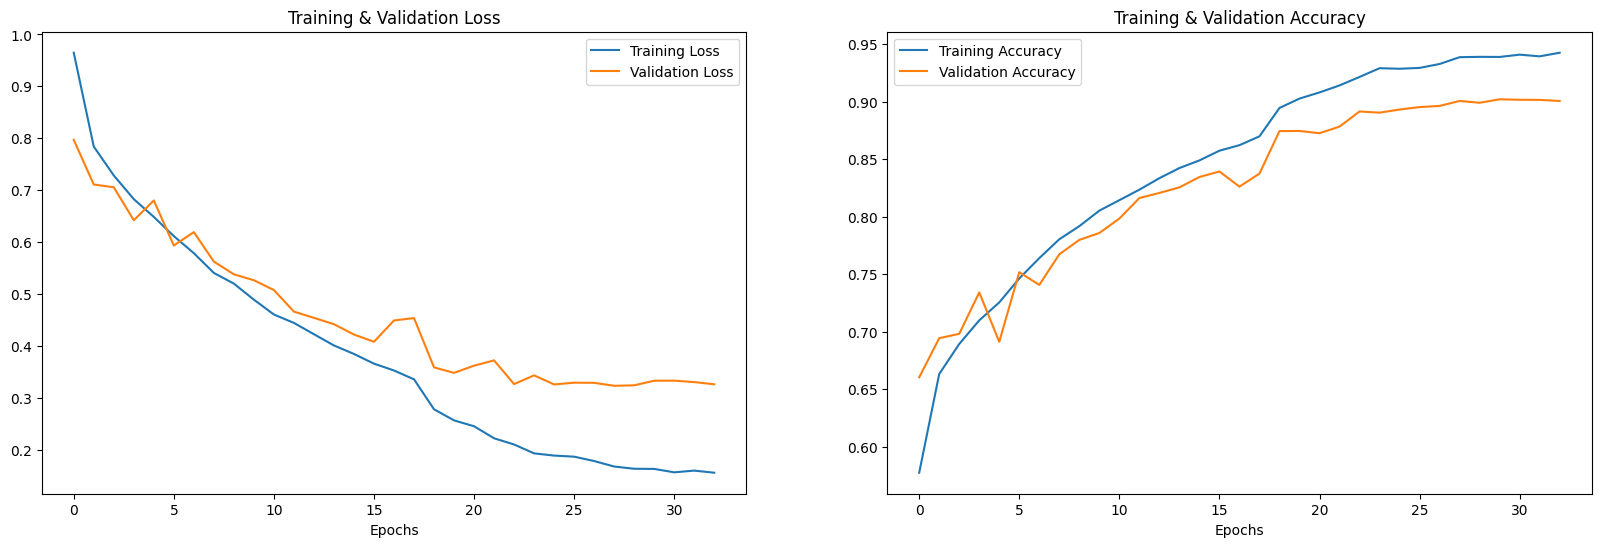

In [34]:
print("Accuracy of our model on test data : ", model.evaluate(X_test, y_test)[1] * 100, "%")

epochs = [i for i in range(len(history.history['accuracy']))]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, val_acc, label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [35]:
# Predicting on test data.
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_true = encoder.inverse_transform(y_test)

240/240 [==============================] - 6s 14ms/step


In [36]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_true.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,sad
1,angry,angry
2,neutral,happy
3,sad,sad
4,neutral,neutral
5,happy,happy
6,sad,sad
7,happy,happy
8,angry,angry
9,angry,angry


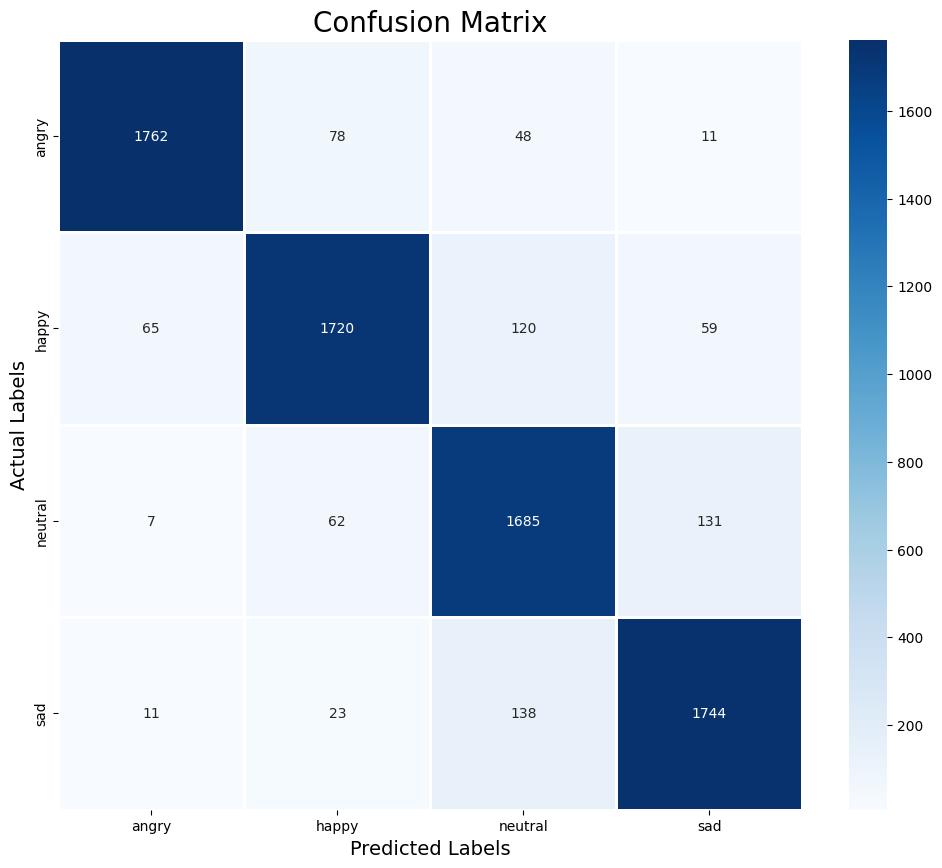

In [37]:
# Extracting class labels from the encoder
class_labels = encoder.categories_[0]

cm = confusion_matrix(y_true, y_pred, labels=class_labels)
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='d')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [38]:
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.96      0.93      0.94      1899
       happy       0.91      0.88      0.89      1964
     neutral       0.85      0.89      0.87      1885
         sad       0.90      0.91      0.90      1916

    accuracy                           0.90      7664
   macro avg       0.90      0.90      0.90      7664
weighted avg       0.90      0.90      0.90      7664



# Saving Model